In [1]:
import os
_, current_folder_name = os.path.split(os.getcwd())
if current_folder_name == "notebooks":
    os.chdir("..")  
print(os.getcwd())  

/gpfs/data/oermannlab/users/ngok02/ModelCollapse/vae


In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [3]:
latent_dims = 20
lstm_dims = 128
K_vecs = 512
num_epochs = 30
batch_size = 256
collapse_size = 2560
patch_size = 4
emb_size = 32
height = width = 28
capacity = 64
learning_rate = 1e-3
variational_beta = 1
alpha = 0.1
gamma=15
beta=0.25
nl_stdev = 1
ng_stdev = 100
generations = 20

In [4]:
train_dataset = datasets.MNIST(root='../data', train = True, download = True, transform = ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='../data', train = False, download = True, transform = ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# device = 'cpu'
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [38]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_dims, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(lstm_dims, lstm_dims // 4)
        self.fc2 = nn.Linear(lstm_dims // 4, 1)

    def forward(self, x, sos=None):
        logits, _ = self.lstm(x)
        logits = F.relu(self.fc1(logits))
        logits = self.fc2(logits)
        out = F.sigmoid(logits)
        return out

In [55]:
def train_lstm(lstm, train_dataloader, debug=False):
    lstm = lstm.to(device)

    if debug:
        num_params = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
        print('Number of parameters: %d' % num_params)

    optimizer = torch.optim.Adam(params=lstm.parameters(), lr=learning_rate, weight_decay=1e-5)

    lstm.train()

    train_loss_avg = []

    if debug:
        print('Training ...')
    for epoch in range(num_epochs):
        train_loss_avg.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:

            image_batch = image_batch.to(device)
            batch_sz = image_batch.shape[0]

            # # reconstruction error
            # loss = F.cross_entropy(logits, encoding_indices_eos)
            sequence = torch.cat((-1 * torch.ones(batch_sz, 1).to(device), image_batch.view(batch_sz, -1)), dim=-1)
            input_sequence = sequence[:,:-1].unsqueeze(-1)
            targets = sequence[:,1:].unsqueeze(-1)

            preds = lstm(input_sequence)

            loss = F.binary_cross_entropy(preds, targets)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()

            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1

        train_loss_avg[-1] /= num_batches
        if debug:
            print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

In [56]:
lstm = LSTM()

In [ ]:
train_lstm(lstm, train_dataloader, debug=True)

Number of parameters: 203329
Training ...
Epoch [1 / 30] average reconstruction error: 0.341608
Epoch [2 / 30] average reconstruction error: 0.125410
Epoch [3 / 30] average reconstruction error: 0.105145
Epoch [4 / 30] average reconstruction error: 0.096852
Epoch [5 / 30] average reconstruction error: 0.093626
Epoch [6 / 30] average reconstruction error: 0.096669
Epoch [7 / 30] average reconstruction error: 0.089490
Epoch [8 / 30] average reconstruction error: 0.087442
Epoch [9 / 30] average reconstruction error: 0.086002
Epoch [10 / 30] average reconstruction error: 0.085046
Epoch [11 / 30] average reconstruction error: 0.084276
Epoch [12 / 30] average reconstruction error: 0.083805
Epoch [13 / 30] average reconstruction error: 0.083255
Epoch [14 / 30] average reconstruction error: 0.082649
Epoch [15 / 30] average reconstruction error: 0.082599
Epoch [16 / 30] average reconstruction error: 0.082010


In [ ]:
pixels = -1 * torch.ones((1,1)).to(device)
for i in range(784):
    outputs = lstm(pixels)
    pixels = torch.cat((pixels, outputs[-1].unsqueeze(0)))
pixels = pixels[1:].view(28,28).unsqueeze(0)

In [50]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

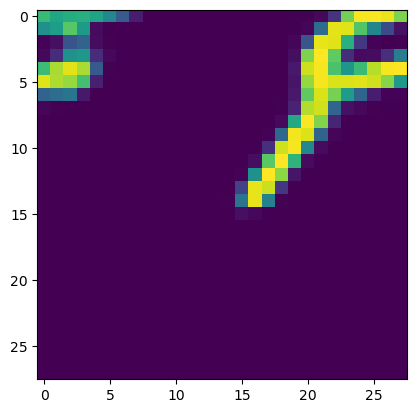

In [51]:
show_image(pixels.detach().cpu())